In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

from scikeras.wrappers import KerasClassifier

from tensorflow import keras
from keras.optimizers import Adam, SGD
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, TextVectorization, Input, LSTM, Dropout, Bidirectional, SpatialDropout1D
from keras.layers import SimpleRNN
from keras.datasets import imdb
from keras import initializers

In [28]:
imdb_df = pd.read_csv('movie.csv', index_col=None)

In [29]:
imdb_df.head(5)

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [30]:
imdb_df.shape

(40000, 2)

In [31]:
twitter_df = pd.read_csv('twitter_training.csv', header=None, index_col=None)

In [32]:
twitter_df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [33]:
twitter_df.shape

(74682, 4)

In [34]:
twitter_df = twitter_df.drop(columns=[0, 1])

In [35]:
twitter_df.head()

,2,3
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [36]:
twitter_df = twitter_df.rename(columns={2: 'label', 3: 'text'})

In [37]:
twitter_df.head()

,label,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [11]:
twitter_df.shape

(74682, 2)

In [12]:
twitter_df = twitter_df.replace({'label': {'Positive': 1, 'Negative': 0}})

In [13]:
full_df = pd.concat([imdb_df, twitter_df], ignore_index=True)

In [14]:
full_df.shape

(114682, 2)

In [38]:
full_df.label.value_counts()

label
0    42561
1    40813
Name: count, dtype: int64

In [16]:
full_df = full_df[full_df['label'].isin([0, 1])]

In [17]:
full_df.shape

(83374, 2)

In [18]:
full_df.label.value_counts()

label
0    42561
1    40813
Name: count, dtype: int64

In [19]:
full_df['text'] = full_df['text'].str.replace(r'<[^>]+>', '', regex=True)

In [20]:
def tfidf_wordcloud(texts, stopwords):
    vectorizer = TfidfVectorizer(
        stop_words=stopwords,
        max_df=0.8,
        min_df=5      
    )
    tfidf = vectorizer.fit_transform(texts)
    scores = tfidf.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    return dict(zip(words, scores))

In [21]:
pos_text = " ".join(full_df.loc[full_df['label'] == 1, 'text'].astype(str))
neg_text = " ".join(full_df.loc[full_df['label'] == 0, 'text'].astype(str))
vis_stopwords = set(stopwords.words('english')) - {'no', 'nor', 'never', 'ain\'t'} | {'movie', 'film', 'one'}

pos_freq = tfidf_wordcloud(
    full_df[full_df.label == 1]["text"].astype(str),
    list(vis_stopwords)
)

neg_freq = tfidf_wordcloud(
    full_df[full_df.label == 0]["text"].astype(str),
    list(vis_stopwords)
)

In [22]:
pos_wordcloud = WordCloud(
                    width=800,
                    height=400,
                    background_color="white"
                ).generate_from_frequencies(pos_freq)

In [23]:
neg_wordcloud = WordCloud(
                    width=800,
                    height=400,
                    background_color="white"
                ).generate_from_frequencies(neg_freq)

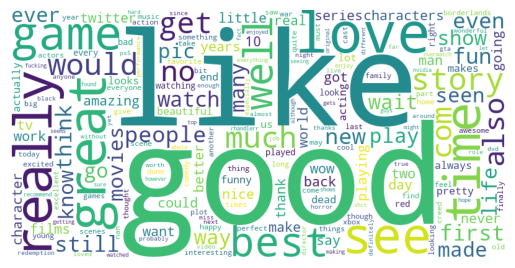

In [24]:
plt.imshow(pos_wordcloud)
plt.axis("off")
plt.show()

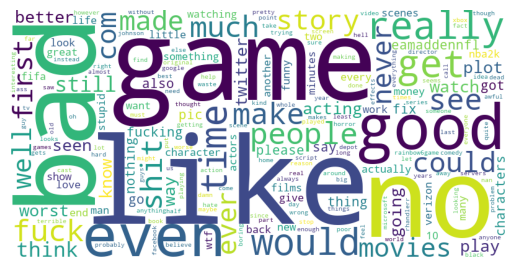

In [25]:
plt.imshow(neg_wordcloud)
plt.axis("off")
plt.show()

In [26]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pokem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pokem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pokem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
def preprocess(text):
    if not isinstance(text, str):
        return ''
    # Remove tags
    text = re.sub('<.*?>', ' ', text)
    # Keep only words 
    text = re.sub('[^a-zA-Z]+', ' ', text)

    text = text.lower()
    stop_words = set(stopwords.words('english')) - {'no', 'not', 'nor', 'never', 'ain\'t'}

    # Remove stop words
    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text


In [28]:
full_df['clean_text'] = full_df['text'].apply(preprocess)

full_df['clean_text'].head()

0    grew b watching loving thunderbirds mates scho...
1    put movie dvd player sat coke chips expectatio...
2    people not know particular time past like feel...
3    even though great interest biblical movies bor...
4    im die hard dads army fan nothing ever change ...
Name: clean_text, dtype: object

In [29]:
%%time
lemmatizer = WordNetLemmatizer()

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return tokens

full_df['tokens'] = full_df['clean_text'].apply(tokenize)

CPU times: total: 1min 23s
Wall time: 2min 14s


In [30]:
full_df['tokens'][0]

'grew b watching loving thunderbird mate school watched played thunderbird school lunch school wanted virgil scott no one wanted alan counting became art form took child see movie hoping would get glimpse loved child bitterly disappointing high point snappy theme tune not could compare original score thunderbird thankfully early saturday morning one television channel still play rerun series gerry anderson wife created jonatha frakes hand director chair version completely hopeless waste film utter rubbish cgi remake may acceptable replacing marionette homo sapiens subsp sapiens huge error judgment'

In [31]:
vectorizer = TfidfVectorizer( max_features=20000, ngram_range=(1, 2), stop_words='english')

In [32]:
X = vectorizer.fit_transform(full_df['tokens'])
y = full_df['label'].astype('str')

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [35]:
y_train.value_counts()

label
0    27248
1    26111
Name: count, dtype: int64

In [36]:
model_lr = LogisticRegression()

In [37]:
model_lr.fit(X_train, y_train)

predictions_lr = model_lr.predict(X_test)

In [38]:
accuracy_score(y_test, predictions_lr)

0.8642278860569715

In [39]:
model_svc = LinearSVC()

In [40]:
model_svc.fit(X_train, y_train)

predictions_svc = model_svc.predict(X_test)

In [41]:
accuracy_score(y_test, predictions_svc)

0.8755622188905547

In [42]:
max_tokens = 20000
sequence_length = 200

text_vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=None
)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    full_df["tokens"],
    full_df["label"].astype("int32"),
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=42
)

text_vectorizer.adapt(X_train.values)

In [44]:
rnn_hidden_dim = 5
word_embedding_dim = 20
batch_size = 32

model_rnn = Sequential()
model_rnn.add(text_vectorizer)
model_rnn.add(Embedding(max_tokens, word_embedding_dim)) 
model_rnn.add(SpatialDropout1D(0.2))
model_rnn.add(LSTM(128, return_sequences=True))
model_rnn.add(Dropout(0.3))
model_rnn.add(Bidirectional(LSTM(64)))
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(1, activation='sigmoid'))

In [45]:
def compile_model(model, optimizer='adam', learning_rate=0.001):
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [46]:
compile_model(model_rnn, 'adam', 0.001)

<Sequential name=sequential, built=False>

In [47]:
model_rnn.fit(X_train.values, y_train.values,
          batch_size=batch_size,
          epochs=10,
          validation_data=(X_val.values, y_val.values))

Epoch 1/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 622s 360ms/step - accuracy: 0.7881 - loss: 0.4515 - val_accuracy: 0.8578 - val_loss: 0.3487
Epoch 2/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 611s 366ms/step - accuracy: 0.8812 - loss: 0.2958 - val_accuracy: 0.8703 - val_loss: 0.3328
Epoch 3/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 621s 366ms/step - accuracy: 0.9049 - loss: 0.2410 - val_accuracy: 0.8740 - val_loss: 0.3154
Epoch 4/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 630s 371ms/step - accuracy: 0.9210 - loss: 0.2030 - val_accuracy: 0.8794 - val_loss: 0.3126
Epoch 5/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 610s 363ms/step - accuracy: 0.9335 - loss: 0.1718 - val_accuracy: 0.8834 - val_loss: 0.3323
Epoch 6/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 595s 357ms/step - accuracy: 0.9444 - loss: 0.1450 - val_accuracy: 0.8813 - val_loss: 0.3576
Epoch 7/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 600s 360ms/step - accuracy: 0.9517 - loss: 0.1235 - val_accuracy: 0.8813 - val_loss: 0.3411
Epoch 8/10
1668/1668 ━━━━━━━━━━━━━━━━━━━━ 598s 358ms/step - ac

In [48]:
score, acc = model_rnn.evaluate(X_test.values, y_test.values,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

522/522 ━━━━━━━━━━━━━━━━━━━━ 105s 200ms/step - accuracy: 0.8835 - loss: 0.4004
Test score: 0.4003962278366089
Test accuracy: 0.8834782838821411


In [49]:
def predict_sentiment(text):
    processed_text = preprocess(text)
    processed_text = tokenize(processed_text)  
    
    text_input = np.array([text.lower()], dtype=object)
    
    prediction_prob = model_rnn.predict(text_input, verbose=0)[0][0]
    
    predicted_label = 'Positive' if prediction_prob > 0.5 else 'Negative'
    
    confidence = prediction_prob if prediction_prob > 0.5 else (1 - prediction_prob)
    
    return {
        'label': predicted_label,
        'confidence': float(confidence),
        'positive_probability': float(prediction_prob),
        'negative_probability': float(1 - prediction_prob)
    }

In [74]:
text = "I went to the movies and saw the worst movie immaginable. No one should ever need to see it"
result = predict_sentiment(text)

In [76]:
print(f"Label: {result['label']}")
print(f"Confidence: {result['confidence']:.2%}")

Label: Negative
Confidence: 97.73%
